## try

In [ ]:
import yfinance as yf
import pandas as pd

def get_sp500_tickers():
    return pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

def fetch_financials(tickers):
    data = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            data.append({
                'Ticker': ticker,
                'MarketCap': info.get('marketCap'),
                'PE': info.get('trailingPE'),
                'PB': info.get('priceToBook'),
                'ROE': info.get('returnOnEquity'),
                'ROA': info.get('returnOnAssets'),
                'ProfitMargin': info.get('profitMargins'),
                'RevenueGrowth': info.get('revenueGrowth'),
                'EPS': info.get('trailingEps'),
                'Beta': info.get('beta')
            })
        except:
            continue
    return pd.DataFrame(data)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

def train_model(df, target='PE'):
    features = ['ROE', 'ROA', 'ProfitMargin', 'RevenueGrowth', 'EPS', 'Beta']
    df = df.dropna(subset=features + [target])
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"[INFO] RMSE: {rmse:.4f}")
    return model, X_test


In [ ]:
import shap
import matplotlib.pyplot as plt

def explain_with_shap(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_similar_companies(df, company_idx, features, top_n=5):
    company = df.iloc[company_idx]
    df['Distance'] = euclidean_distances([company[features]], df[features]).flatten()
    peers = df.sort_values('Distance').iloc[1:top_n+1]
    return company, peers


In [ ]:
# from data_collection import get_sp500_tickers, fetch_financials
# from model_training import train_model
# from explain_model import explain_with_shap
# from relative_valuation import get_similar_companies

# Step 1: Collect Data
tickers = get_sp500_tickers()
df = fetch_financials(tickers)

print(df)


    Ticker     MarketCap         PE          PB      ROE      ROA  \
0      MMM  7.983915e+10  18.474472   17.884268  0.93824  0.05448   
1      AOS  9.139029e+09  17.963686    4.926459  0.27970  0.13353   
2      ABT  2.324078e+11  17.370611    4.761362  0.30649  0.06377   
3     ABBV  3.287447e+11  79.534195  231.480090  0.88400  0.08339   
4      ACN  1.983376e+11  26.118713    6.786189  0.26965  0.11576   
..     ...           ...        ...         ...      ...      ...   
498    XYL  3.067196e+10  33.973045    2.836375  0.08505  0.04441   
499    YUM  4.001028e+10  28.673307   -5.127529      NaN  0.24858   
500   ZBRA  1.473605e+10  27.388468    4.086678  0.16159  0.06539   
501    ZBH  1.823565e+10  20.482222    1.471588  0.07318  0.04418   
502    ZTS  7.507543e+10  30.329138   16.158491  0.52086  0.15108   

     ProfitMargin  RevenueGrowth    EPS   Beta  
0         0.17791         -0.010   8.03  1.076  
1         0.13741         -0.015   3.58  1.278  
2         0.31886       

In [ ]:
import numpy as np
# Step 2: Train Model
model, X_test = train_model(df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 6
[LightGBM] [Info] Start training from score 34.395514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

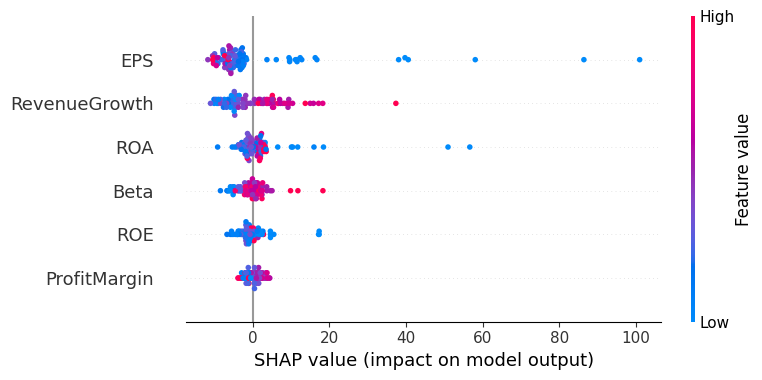

In [ ]:

# Step 3: Explain with SHAP
explain_with_shap(model, X_test)


In [ ]:

# Step 4: Relative Valuation
features = ['ROE', 'ROA', 'ProfitMargin', 'RevenueGrowth', 'EPS', 'Beta']
company, peers = get_similar_companies(df.dropna(), 0, features)

print(f"Target company: {company['Ticker']} | PE: {company['PE']:.2f}")
print(f"Average PE of similar companies: {peers['PE'].mean():.2f}")


Target company: MMM | PE: 18.47
Average PE of similar companies: 25.60


<ipython-input-17-908415c30168>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distance'] = euclidean_distances([company[features]], df[features]).flatten()


In [ ]:
pip install shap lightgbm

✅ RMSE: 31.0294


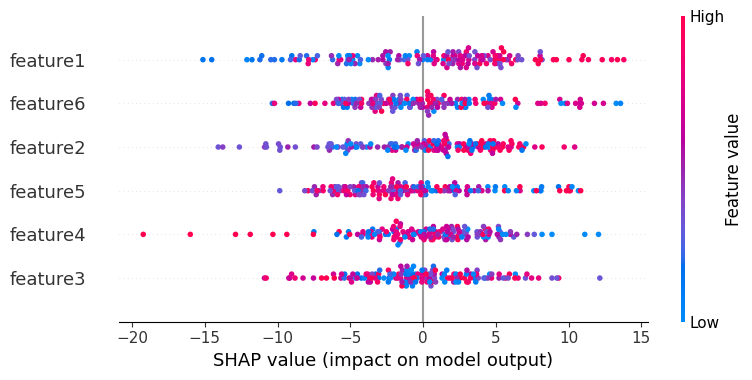

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ==== Step 1: Prepare Data ====
# Example dummy dataset (replace with your actual DataFrame)
data = {
    'feature1': np.random.rand(500),
    'feature2': np.random.rand(500),
    'feature3': np.random.rand(500),
    'feature4': np.random.rand(500),
    'feature5': np.random.rand(500),
    'feature6': np.random.rand(500),
    'target': np.random.rand(500) * 100
}
df = pd.DataFrame(data)

# ==== Step 2: Split data ====
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ==== Step 3: Train LightGBM Model ====
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}
model = lgb.train(params, train_data, num_boost_round=100)

# ==== Step 4: Evaluate Model ====
y_pred = model.predict(X_test)

# Fix for older sklearn (no `squared=False`)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ RMSE: {rmse:.4f}")

# ==== Step 5: Explain with SHAP ====
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


## second one

In [ ]:
pip install yfinance lightgbm pandas numpy scikit-learn

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import datetime


In [ ]:
dow_tickers = [
    'AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
    'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
    'MRK', 'MSFT', 'NKE', 'NVDA', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'
]


In [ ]:
def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'ticker': ticker,
        'market_cap': info.get('marketCap'),
        'book_value': info.get('bookValue'),
        'price_to_book': info.get('priceToBook'),
        'trailing_pe': info.get('trailingPE'),
        'forward_pe': info.get('forwardPE'),
        'peg_ratio': info.get('pegRatio'),
        'dividend_yield': info.get('dividendYield'),
        'profit_margins': info.get('profitMargins'),
        'return_on_assets': info.get('returnOnAssets'),
        'return_on_equity': info.get('returnOnEquity'),
        'debt_to_equity': info.get('debtToEquity'),
        'current_price': info.get('currentPrice')
    }

fundamental_data = []
for ticker in dow_tickers:
    try:
        data = get_fundamentals(ticker)
        if data['book_value'] and data['market_cap'] and data['current_price']:
            fundamental_data.append(data)
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
df = pd.DataFrame(fundamental_data)

# Drop only rows that absolutely cannot work
df = df.dropna(subset=['book_value', 'price_to_book', 'current_price'])

# Fill non-critical fields with zero (or mean later)
df.fillna(0, inplace=True)


<ipython-input-3-4118750975>:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


In [ ]:
target = 'price_to_book'

features = [
    'market_cap', 'book_value', 'trailing_pe', 'forward_pe', 'peg_ratio',
    'dividend_yield', 'profit_margins', 'return_on_assets',
    'return_on_equity', 'debt_to_equity'
]

X = df[features]
y = df[target]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'LightGBM RMSE on Test Set: {rmse:.4f}')


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score 4.939699
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

## From book value

In [ ]:
df['predicted_pb'] = model.predict(df[features])
df['implied_price'] = df['predicted_pb'] * df['book_value']
df['actual_price'] = df['current_price']

def valuation_status(row):
    if row['implied_price'] > row['actual_price']:
        return 'Undervalued'
    elif row['implied_price'] < row['actual_price']:
        return 'Overvalued'
    else:
        return 'Fairly Valued'

df['valuation_status'] = df.apply(valuation_status, axis=1)


In [ ]:
final = df[['ticker', 'actual_price', 'implied_price','predicted_pb','book_value', 'valuation_status']]
print(final.sort_values('valuation_status'))

   ticker  actual_price  implied_price  predicted_pb  book_value  \
0    AAPL        195.64      22.085393      4.939699       4.471   
27      V        357.84      97.810975      4.939699      19.801   
24     PG        158.52     108.485663      4.939699      21.962   
23   NVDA        144.12      16.982684      4.939699       3.438   
22    NKE         60.00      46.843163      4.939699       9.483   
21   MSFT        478.04     213.888955      4.939699      43.300   
19    MMM        142.21      40.974801      4.939699       8.295   
18    MCD        292.31     -23.863685      4.939699      -4.831   
17     KO         69.62      30.072886      4.939699       6.088   
13    IBM        283.05     142.865967      4.939699      28.922   
12    HON        221.79     134.221494      4.939699      27.172   
30    WMT         94.25      51.827319      4.939699      10.492   
1    AMGN        290.05      57.023882      4.939699      11.544   
2     AXP        292.81     219.870930      4.93

## Peg_Ratio

In [ ]:
target = 'trailing_pe'

features = [
    'market_cap', 'book_value', 'trailing_pe', 'forward_pe', 'peg_ratio',
    'dividend_yield', 'profit_margins', 'return_on_assets',
    'return_on_equity', 'debt_to_equity'
]

X = df[features]
y = df[target]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'LightGBM RMSE on Test Set: {rmse:.4f}')


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score 21.738626
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

In [ ]:
df['predicted_pe'] = model.predict(df[features])
# df['implied_price'] = df['predicted_peg'] * df['book_value']
# df['actual_price'] = df['current_price']

# def valuation_status(row):
#     if row['implied_price'] > row['actual_price']:
#         return 'Undervalued'
#     elif row['implied_price'] < row['actual_price']:
#         return 'Overvalued'
#     else:
#         return 'Fairly Valued'

# df['valuation_status'] = df.apply(valuation_status, axis=1)

In [ ]:
df[['ticker', 'actual_price', 'trailing_pe','predicted_pe','book_value']]

,ticker,actual_price,trailing_pe,predicted_pe,book_value
0,AAPL,195.64,30.473520,21.738626,4.471
1,AMGN,290.05,26.464415,21.738626,11.544
2,AXP,292.81,20.447626,21.738626,44.511
3,BA,200.26,0.000000,21.738626,-4.421
4,CAT,357.68,17.671936,21.738626,38.355
5,CRM,262.76,41.314465,21.738626,63.326
6,CSCO,65.33,26.665306,21.738626,11.600
7,CVX,148.85,17.011429,21.738626,85.458
8,DIS,118.13,24.407024,21.738626,57.934
9,DOW,29.44,75.487180,21.738626,23.750


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] Start training from score 310.790002
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

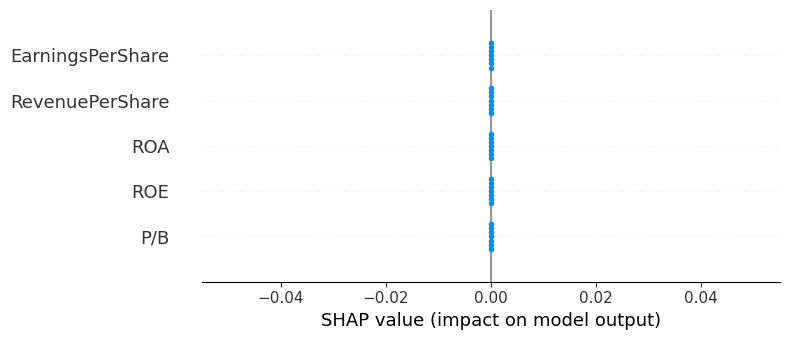

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# Sample universe of tickers (you can expand this)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'INTC']

def get_fundamentals(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'Ticker': ticker,
            'P/E': info.get('trailingPE'),
            'P/B': info.get('priceToBook'),
            'ROE': info.get('returnOnEquity'),
            'ROA': info.get('returnOnAssets'),
            'RevenuePerShare': info.get('revenuePerShare'),
            'EarningsPerShare': info.get('trailingEps'),
            'CurrentPrice': info.get('currentPrice'),
            'MarketCap': info.get('marketCap'),
            'Sector': info.get('sector')
        }
    except:
        return None

# Get all data
data = [get_fundamentals(t) for t in tickers]
df = pd.DataFrame([x for x in data if x is not None])
df.dropna(inplace=True)

# Define features and target
features = ['P/B', 'ROE', 'ROA', 'RevenuePerShare', 'EarningsPerShare']
target = 'CurrentPrice'

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target]

# Train LightGBM model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Predict valuations
df['PredictedPrice'] = model.predict(scaler.transform(df[features]))
df['ValuationGap'] = df['PredictedPrice'] - df['CurrentPrice']
df['ValuationSignal'] = np.where(df['ValuationGap'] > 0, 'Undervalued', 'Overvalued')

# Show ranking
valuation_df = df[['Ticker', 'CurrentPrice', 'PredictedPrice', 'ValuationGap', 'ValuationSignal']]
print("\n📊 Relative Valuation Output:")
print(valuation_df.sort_values(by='ValuationGap', ascending=False))

# SHAP values for interpretability
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot SHAP summary
shap.summary_plot(shap_values, features=features, feature_names=features)


Step 1 - Tickers to be processed:
 ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'INTC']

Step 3 - Raw financial data collected:
   Ticker         P/E        P/B      ROE      ROA  RevenuePerShare  \
0   AAPL   30.962616  44.459850  1.38015  0.23810           26.455   
1   MSFT   36.495754  10.915011  0.33610  0.14582           36.325   
2  GOOGL   19.793528   6.243619  0.34789  0.16897           29.338   
3   AMZN   34.723125   7.397641  0.25240  0.07632           61.785   
4   NVDA   46.074196  41.544502  1.15463  0.53245            6.059   
5   TSLA  185.471590  14.079968  0.08774  0.03724           29.867   
6   META   27.104256   9.465073  0.39835  0.17880           67.349   
7   INTC         NaN   0.904281 -0.18127 -0.01092           12.321   

   EarningsPerShare  CurrentPrice      MarketCap                  Sector  
0              6.42        198.78  2968938348544              Technology  
1             12.95        472.62  3512767086592              Technology  
2 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


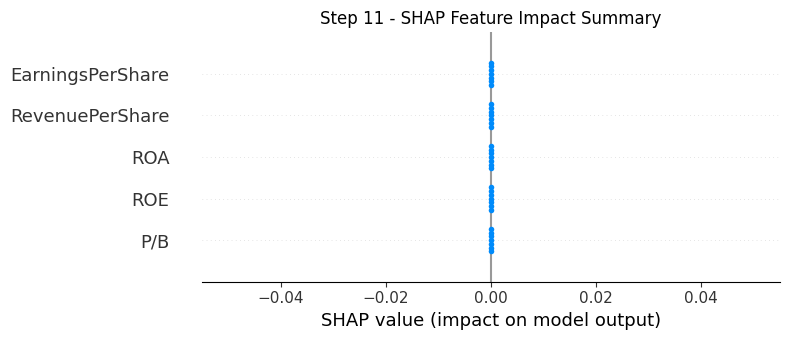

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# Step 1: Define tickers (Input: list of ticker symbols)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'INTC']
print("Step 1 - Tickers to be processed:\n", tickers)

# Step 2: Download fundamental data (Input: ticker symbols, Output: DataFrame of financial metrics)
def get_fundamentals(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'Ticker': ticker,
            'P/E': info.get('trailingPE'),
            'P/B': info.get('priceToBook'),
            'ROE': info.get('returnOnEquity'),
            'ROA': info.get('returnOnAssets'),
            'RevenuePerShare': info.get('revenuePerShare'),
            'EarningsPerShare': info.get('trailingEps'),
            'CurrentPrice': info.get('currentPrice'),
            'MarketCap': info.get('marketCap'),
            'Sector': info.get('sector')
        }
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return None

# Step 3: Collect data for all tickers
data = [get_fundamentals(t) for t in tickers]
df = pd.DataFrame([x for x in data if x is not None])
print("\nStep 3 - Raw financial data collected:\n", df)

# Step 4: Drop rows with missing values (Input: df, Output: clean df)
df.dropna(inplace=True)
print("\nStep 4 - Data after dropping NA:\n", df)

# Step 5: Define features and target (Input: cleaned df)
features = ['P/B', 'ROE', 'ROA', 'RevenuePerShare', 'EarningsPerShare']
target = 'CurrentPrice'
print("\nStep 5 - Selected Features:\n", features)
print("\nTarget:\n", target)

# Step 6: Normalize features (Input: features, Output: scaled features)
scaler = StandardScaler()
X = scaler.fit_transform(df[features])
y = df[target]
print("\nStep 6 - Scaled Feature Sample:\n", pd.DataFrame(X, columns=features).head())

# Step 7: Train-test split (Input: X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nStep 7 - Train/Test Split:")
print(f"Train Size: {X_train.shape[0]}, Test Size: {X_test.shape[0]}")

# Step 8: Train LightGBM model (Input: X_train, y_train, Output: trained model)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
print("\nStep 8 - LightGBM model trained.")

# Step 9: Predict stock prices (Input: model, scaled X, Output: predicted prices)
df['PredictedPrice'] = model.predict(scaler.transform(df[features]))
df['ValuationGap'] = df['PredictedPrice'] - df['CurrentPrice']
df['ValuationSignal'] = np.where(df['ValuationGap'] > 0, 'Undervalued', 'Overvalued')

print("\nStep 9 - Model predictions and valuation signals:\n", df[['Ticker', 'CurrentPrice', 'PredictedPrice', 'ValuationGap', 'ValuationSignal']])

# Step 10: SHAP analysis (Input: model, X)
explainer = shap.Explainer(model)
shap_values = explainer(X)
print("\nStep 10 - SHAP values computed.")

# Step 11: SHAP summary plot (Output: visualization)
shap.summary_plot(shap_values, features=features, feature_names=features, show=False)
plt.title("Step 11 - SHAP Feature Impact Summary")
plt.tight_layout()
plt.show()


## GPT

In [ ]:
# File: setup_environment.py

# Install required libraries (run in terminal or Jupyter cell)
# pip install pandas numpy lightgbm scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# File: data_preprocessing.py

def load_mock_financial_data():
    # Simulate firm fundamentals for illustration
    np.random.seed(42)
    n_firms = 1000
    data = pd.DataFrame({
        'firm_id': np.random.choice(range(1, 500), n_firms),
        'date': pd.date_range(start='2000-01-01', periods=n_firms, freq='M'),
        'book_value': np.random.uniform(1e6, 1e9, n_firms),
        'market_value': np.random.uniform(1e6, 1e9, n_firms),
        'EV': np.random.uniform(1e6, 1e9, n_firms),
        'sales': np.random.uniform(1e6, 1e9, n_firms),
        'total_assets': np.random.uniform(1e6, 1e9, n_firms),
        'ROA': np.random.uniform(-0.1, 0.3, n_firms),
        'leverage': np.random.uniform(0, 1, n_firms),
        'ipo_flag': np.random.choice([0, 1], n_firms),
        'industry': np.random.choice(['Tech', 'Health', 'Energy', 'Finance'], n_firms)
    })

    # Compute target ratios (used for training)
    data['log_m2b'] = np.log(data['market_value'] / data['book_value'])
    data['log_ev_sales'] = np.log(data['EV'] / data['sales'])
    data['log_ev_assets'] = np.log(data['EV'] / data['total_assets'])

    return data


In [ ]:
# File: model_training.py

def train_lightgbm(X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'verbose': -1
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(params,
                      train_data,
                      num_boost_round=500,
                      valid_sets=[train_data, val_data],
                      early_stopping_rounds=50,
                      verbose_eval=False)

    return model


In [ ]:
# File: rolling_train_test.py

def run_monthly_loop(data):
    results = []
    monthly_dates = sorted(data['date'].dt.to_period('M').unique())

    for current_month in monthly_dates[60:]:  # skip first 5 years for rolling
        df_month = data[data['date'].dt.to_period('M') == current_month]

        if len(df_month) < 50:
            continue

        X = df_month[['ROA', 'leverage']]  # example features
        y = df_month['log_m2b']

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)

        results.append({
            'month': str(current_month),
            'mse': mse
        })

    return pd.DataFrame(results)


In [ ]:
# File: rolling_train_test.py

def run_monthly_loop(data):
    results = []
    monthly_dates = sorted(data['date'].dt.to_period('M').unique())

    for current_month in monthly_dates[60:]:  # skip first 5 years for rolling
        df_month = data[data['date'].dt.to_period('M') == current_month]

        if len(df_month) < 50:
            continue

        X = df_month[['ROA', 'leverage']]  # example features
        y = df_month['log_m2b']

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)

        results.append({
            'month': str(current_month),
            'mse': mse
        })

    return pd.DataFrame(results)


In [ ]:
# File: valuation_prediction.py

def predict_and_evaluate_equity_value(model, df_test, features, log_target_col, book_value_col, market_value_col):
    # Predict log(multiple)
    X_test = df_test[features]
    y_pred_log = model.predict(X_test)

    # Back-transform to get predicted market value
    df_test['predicted_mv'] = np.exp(y_pred_log) * df_test[book_value_col]

    # Calculate valuation error
    df_test['valuation_error'] = (df_test['predicted_mv'] - df_test[market_value_col]) / df_test[market_value_col]

    return df_test


In [ ]:
# File: return_analysis.py

def assign_quintiles(df, column='valuation_error'):
    df = df.copy()
    df['quintile'] = pd.qcut(df[column], 5, labels=False) + 1
    return df

def simulate_future_returns(df):
    # Simulate next-month returns
    df['next_month_return'] = np.random.normal(loc=0.01, scale=0.05, size=len(df))
    return df

def analyze_returns_by_quintile(df):
    grouped = df.groupby('quintile')['next_month_return'].mean()
    return grouped


In [ ]:
# File: explainability.py
import shap

def explain_with_shap(model, X_sample):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, plot_type="bar")
    return shap_values


In [ ]:
# File: main.py

# from data_preprocessing import load_mock_financial_data
# from model_training import train_lightgbm
# from rolling_train_test import run_monthly_loop
# from valuation_prediction import predict_and_evaluate_equity_value
# from return_analysis import simulate_future_returns, assign_quintiles, analyze_returns_by_quintile
# from explainability import explain_with_shap

def main():
    data = load_mock_financial_data()
    monthly_results = []

    unique_months = sorted(data['date'].dt.to_period('M').unique())

    for month in unique_months[60:]:  # Skip warmup period
        df_month = data[data['date'].dt.to_period('M') == month]

        if len(df_month) < 50:
            continue

        features = ['ROA', 'leverage']
        X = df_month[features]
        y = df_month['log_m2b']
        bv = df_month['book_value']
        mv = df_month['market_value']

        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        # Predict & compute valuation errors
        df_test = df_month.iloc[X_test.index]
        df_test = predict_and_evaluate_equity_value(model, df_test, features, 'log_m2b', 'book_value', 'market_value')

        # Return prediction test
        df_test = simulate_future_returns(df_test)
        df_test = assign_quintiles(df_test)
        quintile_returns = analyze_returns_by_quintile(df_test)

        monthly_results.append({
            'month': str(month),
            'quintile_returns': quintile_returns.to_dict()
        })

    return monthly_results


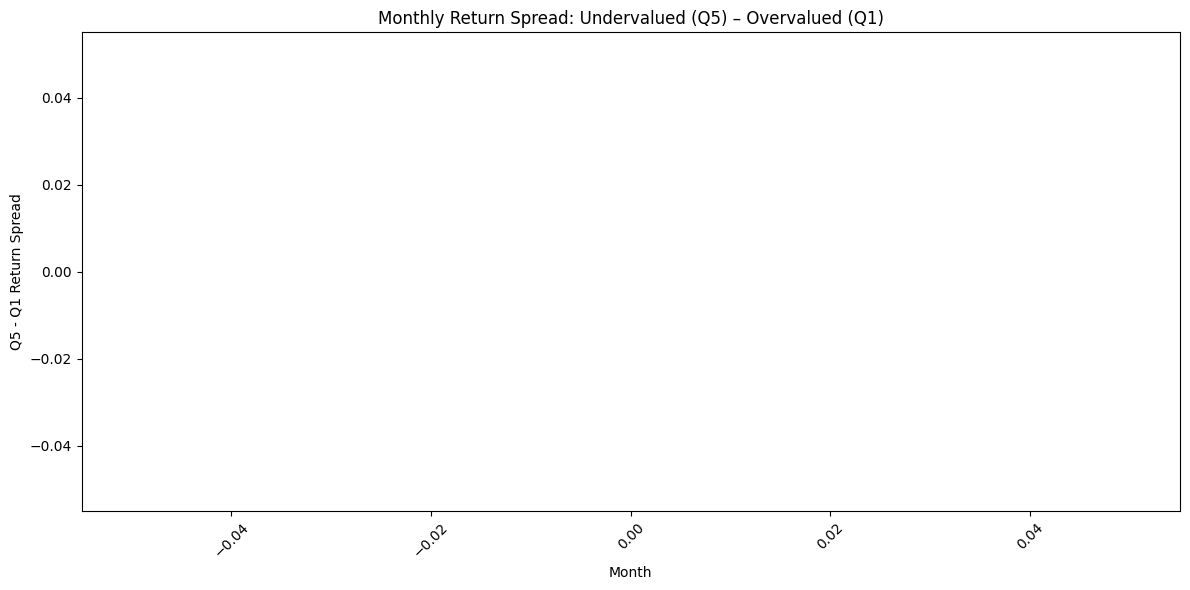

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Step 1: Load mock financial data
def load_mock_financial_data():
    np.random.seed(42)
    n_firms = 3000
    dates = pd.date_range(start='2005-01-01', periods=n_firms, freq='M')
    data = pd.DataFrame({
        'firm_id': np.random.choice(range(1, 500), n_firms),
        'date': dates,
        'book_value': np.random.uniform(1e6, 1e9, n_firms),
        'market_value': np.random.uniform(1e6, 1e9, n_firms),
        'EV': np.random.uniform(1e6, 1e9, n_firms),
        'sales': np.random.uniform(1e6, 1e9, n_firms),
        'total_assets': np.random.uniform(1e6, 1e9, n_firms),
        'ROA': np.random.uniform(-0.1, 0.3, n_firms),
        'leverage': np.random.uniform(0, 1, n_firms),
        'ipo_flag': np.random.choice([0, 1], n_firms),
        'industry': np.random.choice(['Tech', 'Health', 'Energy', 'Finance'], n_firms)
    })
    data['log_m2b'] = np.log(data['market_value'] / data['book_value'])
    data['log_ev_sales'] = np.log(data['EV'] / data['sales'])
    data['log_ev_assets'] = np.log(data['EV'] / data['total_assets'])
    return data

# Step 2: Train LightGBM model
def train_lightgbm(X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    model = lgb.train(params,
                      train_data,
                      num_boost_round=500,
                      valid_sets=[train_data, val_data],
                      early_stopping_rounds=50,
                      verbose_eval=False)
    return model

# Step 3: Predict and evaluate valuation
def predict_and_evaluate_equity_value(model, df_test, features, log_target_col, book_value_col, market_value_col):
    X_test = df_test[features]
    y_pred_log = model.predict(X_test)
    df_test['predicted_mv'] = np.exp(y_pred_log) * df_test[book_value_col]
    df_test['valuation_error'] = (df_test['predicted_mv'] - df_test[market_value_col]) / df_test[market_value_col]
    return df_test

# Step 4: Assign quintiles and simulate returns
def assign_quintiles(df, column='valuation_error'):
    df = df.copy()
    df['quintile'] = pd.qcut(df[column], 5, labels=False) + 1
    return df

def simulate_future_returns(df):
    df['next_month_return'] = np.random.normal(loc=0.01, scale=0.05, size=len(df))
    return df

def analyze_returns_by_quintile(df):
    grouped = df.groupby('quintile')['next_month_return'].mean()
    return grouped

# Step 5: Main rolling loop
def main():
    data = load_mock_financial_data()
    monthly_results = []
    data['month'] = data['date'].dt.to_period('M')
    unique_months = sorted(data['month'].unique())

    for month in unique_months[60:]:  # Start after 5 years
        df_month = data[data['month'] == month]

        if len(df_month) < 50:
            continue

        features = ['ROA', 'leverage']
        X = df_month[features]
        y = df_month['log_m2b']
        df_month = df_month.reset_index(drop=True)

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        df_test = df_month.loc[X_test.index]
        df_test = predict_and_evaluate_equity_value(model, df_test, features, 'log_m2b', 'book_value', 'market_value')
        df_test = simulate_future_returns(df_test)
        df_test = assign_quintiles(df_test)
        quintile_returns = analyze_returns_by_quintile(df_test)

        monthly_results.append({
            'month': str(month),
            'quintile_returns': quintile_returns.to_dict()
        })

    return monthly_results

# Run and display result
results = main()

# Extract and plot return spread
dates, spreads = [], []
for r in results:
    qr = r['quintile_returns']
    if 5 in qr and 1 in qr:
        dates.append(r['month'])
        spreads.append(qr[5] - qr[1])
        print(f"Month: {r['month']} | Q5 - Q1 Return Spread: {qr[5] - qr[1]:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(dates, spreads, marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Return Spread: Undervalued (Q5) – Overvalued (Q1)")
plt.xlabel("Month")
plt.ylabel("Q5 - Q1 Return Spread")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")

# Step 1: Load mock financial data
def load_mock_financial_data():
    np.random.seed(42)
    n_firms = 3000
    dates = pd.date_range(start='2005-01-01', periods=n_firms, freq='M')
    data = pd.DataFrame({
        'firm_id': np.random.choice(range(1, 500), n_firms),
        'date': dates,
        'book_value': np.random.uniform(1e6, 1e9, n_firms),
        'market_value': np.random.uniform(1e6, 1e9, n_firms),
        'EV': np.random.uniform(1e6, 1e9, n_firms),
        'sales': np.random.uniform(1e6, 1e9, n_firms),
        'total_assets': np.random.uniform(1e6, 1e9, n_firms),
        'ROA': np.random.uniform(-0.1, 0.3, n_firms),
        'leverage': np.random.uniform(0, 1, n_firms),
        'ipo_flag': np.random.choice([0, 1], n_firms),
        'industry': np.random.choice(['Tech', 'Health', 'Energy', 'Finance'], n_firms)
    })
    data['log_m2b'] = np.log(data['market_value'] / data['book_value'])
    data['log_ev_sales'] = np.log(data['EV'] / data['sales'])
    data['log_ev_assets'] = np.log(data['EV'] / data['total_assets'])
    return data

# Train LightGBM model
def train_lightgbm(X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    model = lgb.train(params,
                      train_data,
                      num_boost_round=500,
                      valid_sets=[train_data, val_data],
                      early_stopping_rounds=50,
                      verbose_eval=False)
    return model

# Predict and evaluate valuation
def predict_and_evaluate_equity_value(model, df_test, features, log_target_col, book_value_col, market_value_col):
    X_test = df_test[features]
    y_pred_log = model.predict(X_test)
    df_test['predicted_mv'] = np.exp(y_pred_log) * df_test[book_value_col]
    df_test['valuation_error'] = (df_test['predicted_mv'] - df_test[market_value_col]) / df_test[market_value_col]
    return df_test

# Assign quintiles and simulate returns
def assign_quintiles(df, column='valuation_error'):
    df = df.copy()
    df['quintile'] = pd.qcut(df[column], 5, labels=False) + 1
    return df

def simulate_future_returns(df):
    df['next_month_return'] = np.random.normal(loc=0.01, scale=0.05, size=len(df))
    return df

def analyze_returns_by_quintile(df):
    grouped = df.groupby('quintile')['next_month_return'].mean()
    return grouped

# Main rolling loop
def main():
    data = load_mock_financial_data()
    monthly_results = []
    data['month'] = data['date'].dt.to_period('M')
    unique_months = sorted(data['month'].unique())

    for month in unique_months[60:]:  # Start after 5 years
        df_month = data[data['month'] == month]

        if len(df_month) < 50:
            continue

        features = ['ROA', 'leverage']
        X = df_month[features]
        y = df_month['log_m2b']
        df_month = df_month.reset_index(drop=True)

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        model = train_lightgbm(X_train, y_train, X_val, y_val)

        df_test = df_month.loc[X_test.index]
        df_test = predict_and_evaluate_equity_value(model, df_test, features, 'log_m2b', 'book_value', 'market_value')
        df_test = simulate_future_returns(df_test)
        df_test = assign_quintiles(df_test)
        quintile_returns = analyze_returns_by_quintile(df_test)

        monthly_results.append({
            'month': str(month),
            'quintile_returns': quintile_returns.to_dict()
        })

    return monthly_results

# Run and prepare plot
results = main()

dates, spreads = [], []
for r in results:
    qr = r['quintile_returns']
    if 5 in qr and 1 in qr:
        dates.append(r['month'])
        spreads.append(qr[5] - qr[1])

# Save results to a notebook-friendly format
results_df = pd.DataFrame({'month': dates, 'spread': spreads})
import ace_tools as tools; tools.display_dataframe_to_user(name="Monthly Return Spreads", dataframe=results_df)


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")

# Step 1: Load mock financial data
def load_mock_financial_data():
    np.random.seed(42)
    n_firms = 3000
    dates = pd.date_range(start='2005-01-01', periods=n_firms, freq='M')
    data = pd.DataFrame({
        'firm_id': np.random.choice(range(1, 500), n_firms),
        'date': dates,
        'book_value': np.random.uniform(1e6, 1e9, n_firms),
        'market_value': np.random.uniform(1e6, 1e9, n_firms),
        'EV': np.random.uniform(1e6, 1e9, n_firms),
        'sales': np.random.uniform(1e6, 1e9, n_firms),
        'total_assets': np.random.uniform(1e6, 1e9, n_firms),
        'ROA': np.random.uniform(-0.1, 0.3, n_firms),
        'leverage': np.random.uniform(0, 1, n_firms),
        'ipo_flag': np.random.choice([0, 1], n_firms),
        'industry': np.random.choice(['Tech', 'Health', 'Energy', 'Finance'], n_firms)
    })
    data['log_m2b'] = np.log(data['market_value'] / data['book_value'])
    data['log_ev_sales'] = np.log(data['EV'] / data['sales'])
    data['log_ev_assets'] = np.log(data['EV'] / data['total_assets'])
    return data

# Train LightGBM model
def train_lightgbm(X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    model = lgb.train(params,
                      train_data,
                      num_boost_round=500,
                      valid_sets=[train_data, val_data],
                      early_stopping_rounds=50,
                      verbose_eval=False)
    return model

# Predict and evaluate valuation
def predict_and_evaluate_equity_value(model, df_test, features, log_target_col, book_value_col, market_value_col):
    X_test = df_test[features]
    y_pred_log = model.predict(X_test)
    df_test['predicted_mv'] = np.exp(y_pred_log) * df_test[book_value_col]
    df_test['valuation_error'] = (df_test['predicted_mv'] - df_test[market_value_col]) / df_test[market_value_col]
    return df_test

# Assign quintiles and simulate returns
def assign_quintiles(df, column='valuation_error'):
    df = df.copy()
    # Handle potential errors if there are fewer than 5 unique values in the column
    # or if all values are the same.
    try:
        df['quintile'] = pd.qcut(df[column], 5, labels=False, duplicates='drop') + 1
    except ValueError as e:
        print(f"Could not assign 5 quintiles for this month: {e}")
        df['quintile'] = np.nan # Assign NaN if qcut fails
    return df


def simulate_future_returns(df):
    df['next_month_return'] = np.random.normal(loc=0.01, scale=0.05, size=len(df))
    return df

def analyze_returns_by_quintile(df):
    # Only consider rows where quintile was successfully assigned
    grouped = df.dropna(subset=['quintile']).groupby('quintile')['next_month_return'].mean()
    return grouped

# Main rolling loop
def main():
    data = load_mock_financial_data()
    monthly_results = []
    data['month'] = data['date'].dt.to_period('M')
    unique_months = sorted(data['month'].unique())

    for month in unique_months[60:]:  # Start after 5 years
        df_month = data[data['month'] == month]

        if len(df_month) < 50:
            continue

        features = ['ROA', 'leverage']
        # Ensure features exist and are numeric
        features_present = [f for f in features if f in df_month.columns and pd.api.types.is_numeric_dtype(df_month[f])]
        if not features_present:
             print(f"Skipping month {month}: No valid numeric features found.")
             continue

        # Drop rows where target is missing for this month's training
        df_month_cleaned = df_month.dropna(subset=['log_m2b'] + features_present).copy()

        if len(df_month_cleaned) < 50:
            print(f"Skipping month {month}: Less than 50 valid data points for training.")
            continue


        X = df_month_cleaned[features_present]
        y = df_month_cleaned['log_m2b']
        df_month_cleaned = df_month_cleaned.reset_index(drop=True)

        # Ensure enough data for split ratios
        if len(df_month_cleaned) < 1 / 0.2: # Need at least 5 samples for 80/20 split
             print(f"Skipping month {month}: Not enough data points for train/test split.")
             continue


        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 40% * 50% = 20% test size

        # Check if test sets have enough samples for subsequent steps (like qcut)
        if len(X_test) == 0:
             print(f"Skipping month {month}: Test set is empty after splitting.")
             continue


        model = train_lightgbm(X_train, y_train, X_val, y_val)

        # Need the original df_month data to perform the full prediction and analysis
        df_test = df_month.copy()
        # Only keep rows from original df_month that correspond to the test set indices after cleaning and splitting
        # This is a bit tricky because indices might be reset. A safer way is to merge/join later.
        # For now, let's predict on the entire month's data that has features, then filter.
        X_month_predict = df_month.dropna(subset=features_present)[features_present]
        if not X_month_predict.empty:
            df_month_predicted = df_month.copy()
            df_month_predicted = predict_and_evaluate_equity_value(
                 model,
                 df_month_predicted.dropna(subset=features_present).copy(), # Predict only on rows with features
                 features_present,
                 'log_m2b',
                 'book_value',
                 'market_value'
            )
            df_month_predicted = simulate_future_returns(df_month_predicted)
            df_month_predicted = assign_quintiles(df_month_predicted)
            quintile_returns = analyze_returns_by_quintile(df_month_predicted)


            # Check if we have quintile 1 and 5 after analysis
            if 1 in quintile_returns.index and 5 in quintile_returns.index:
                 monthly_results.append({
                     'month': str(month),
                     'quintile_returns': quintile_returns.to_dict()
                 })
            else:
                 print(f"Skipping month {month}: Could not compute Q1 and Q5 returns.")
        else:
             print(f"Skipping month {month}: No data points with valid features for prediction.")


    return monthly_results

# Run and prepare plot
results = main()

dates, spreads = [], []
for r in results:
    qr = r['quintile_returns']
    # Ensure both keys exist before calculating spread
    if 5 in qr and 1 in qr:
        dates.append(r['month'])
        spreads.append(qr[5] - qr[1])
    # Print spread if available
    if 5 in qr and 1 in qr:
         print(f"Month: {r['month']} | Q5 - Q1 Return Spread: {qr[5] - qr[1]:.4f}")


# Save results to a notebook-friendly format
# Replace the problematic line with a standard pandas display
results_df = pd.DataFrame({'month': dates, 'spread': spreads})

# Display the DataFrame using standard print or display
print("\nMonthly Return Spreads (Q5 - Q1):")
display(results_df) # Using display for better formatting in Jupyter

# Plotting the spread
if dates: # Only attempt to plot if there are dates
    plt.figure(figsize=(12, 6))
    # Convert month periods to string or datetime for plotting
    plot_dates = [pd.Period(d).start_time for d in dates]
    plt.plot(plot_dates, spreads, marker='o')
    plt.xticks(rotation=45)
    plt.title("Monthly Return Spread: Undervalued (Q5) – Overvalued (Q1)")
    plt.xlabel("Month")
    plt.ylabel("Q5 - Q1 Return Spread")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo valid monthly spread data to plot.")


Monthly Return Spreads (Q5 - Q1):


,month,spread



No valid monthly spread data to plot.


In [ ]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # Example: list of tickers (you can replace with dow_tickers or any list)
# dow_tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'WMT', 'PG', 'UNH', 'KO', 'DIS', 'INTC']

def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'ticker': ticker,
        'market_cap': info.get('marketCap'),
        'book_value': info.get('bookValue'),
        'price_to_book': info.get('priceToBook'),
        'trailing_pe': info.get('trailingPE'),
        'forward_pe': info.get('forwardPE'),
        'peg_ratio': info.get('pegRatio'),
        'dividend_yield': info.get('dividendYield'),
        'profit_margins': info.get('profitMargins'),
        'return_on_assets': info.get('returnOnAssets'),
        'return_on_equity': info.get('returnOnEquity'),
        'debt_to_equity': info.get('debtToEquity'),
        'current_price': info.get('currentPrice')
    }

# Step 1: Collect fundamental data
fundamental_data = []
for ticker in dow_tickers:
    try:
        data = get_fundamentals(ticker)
        if data['book_value'] and data['current_price']:
            fundamental_data.append(data)
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Step 2: Prepare DataFrame
df = pd.DataFrame(fundamental_data)
df = df.dropna(subset=['book_value', 'current_price'])

# Step 3: Compute log(P/B) as the target
df['log_pb'] = np.log(df['current_price'] / df['book_value'])

# Step 4: Select model features (exclude features that leak price info)
features = [
    'book_value', 'dividend_yield', 'profit_margins',
    'return_on_assets', 'return_on_equity', 'debt_to_equity'
]

# Step 5: Clean data
df[features] = df[features].fillna(0)
X = df[features]
y = df['log_pb']

# Step 6: Train/Test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Step 7: Evaluate
preds_log_pb = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_log_pb))
print(f'LightGBM RMSE on Test Set: {rmse:.4f}')

# Step 8: Predict for all and back-transform
df['predicted_log_pb'] = model.predict(df[features])
df['predicted_pb'] = np.exp(df['predicted_log_pb'])
df['implied_price'] = df['predicted_pb'] * df['book_value']
df['actual_price'] = df['current_price']

# Step 9: Assign valuation label
def valuation_status(row):
    if row['implied_price'] > row['actual_price']:
        return 'Undervalued'
    elif row['implied_price'] < row['actual_price']:
        return 'Overvalued'
    else:
        return 'Fairly Valued'

df['valuation_status'] = df.apply(valuation_status, axis=1)

# Step 10: Display Results
print(df[['ticker', 'actual_price', 'implied_price', 'valuation_status']])


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score 1.636907
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [ ]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # Step 1: Define Tickers
# tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'WMT', 'PG', 'UNH', 'KO', 'DIS', 'INTC']

def get_fundamentals(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'ticker': ticker,
        'industry': info.get('industry'),
        'book_value': info.get('bookValue'),
        'current_price': info.get('currentPrice'),
        'dividend_yield': info.get('dividendYield'),
        'profit_margins': info.get('profitMargins'),
        'return_on_assets': info.get('returnOnAssets'),
        'return_on_equity': info.get('returnOnEquity'),
        'debt_to_equity': info.get('debtToEquity'),
        'revenue_per_share': info.get('revenuePerShare'),
        'earnings_per_share': info.get('trailingEps')
    }

# Step 2: Fetch Data
fundamentals = []
for ticker in dow_tickers:
    try:
        data = get_fundamentals(ticker)
        if data['book_value'] and data['current_price']:
            fundamentals.append(data)
    except Exception as e:
        print(f"Error with {ticker}: {e}")

df = pd.DataFrame(fundamentals)
df = df.dropna(subset=['current_price'])

# Step 3: Create log-price target
df['log_price'] = np.log(df['current_price'])

# Step 4: Clean and encode
categorical = ['industry']
df[categorical] = df[categorical].astype('category')

# ✅ FIX: Safely fill only numeric NaNs
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(0, inplace=True)

features = [
    'book_value', 'dividend_yield', 'profit_margins', 'return_on_assets',
    'return_on_equity', 'debt_to_equity', 'revenue_per_share', 'earnings_per_share', 'industry'
]

X = df[features]
y = df['log_price']

# Step 5: Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Step 6: Predict prices
df['predicted_log_price'] = model.predict(X)
df['predicted_price'] = np.exp(df['predicted_log_price'])

# Step 7: Compare and label
df['actual_price'] = df['current_price']
df['valuation_gap'] = df['predicted_price'] - df['actual_price']

def label(row):
    if row['valuation_gap'] > 5:
        return 'Undervalued'
    elif row['valuation_gap'] < -5:
        return 'Overvalued'
    else:
        return 'Fairly Valued'

df['valuation_status'] = df.apply(label, axis=1)

# Step 8: Show result
print(df[['ticker', 'industry', 'actual_price', 'predicted_price', 'valuation_gap', 'valuation_status']])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 1
[LightGBM] [Info] Start training from score 5.185213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there a

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load S&P 500 tickers
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
tickers = sp500['Symbol'].tolist()

# Fetch fundamentals
def fetch(t):
    info = yf.Ticker(t).info
    return {
        'ticker': t,
        'industry': info.get('industry'),
        'book_value': info.get('bookValue'),
        'current_price': info.get('currentPrice'),
        'div_yield': info.get('dividendYield'),
        'profit_margins': info.get('profitMargins'),
        'roa': info.get('returnOnAssets'),
        'roe': info.get('returnOnEquity'),
        'dte': info.get('debtToEquity'),
        'rev_per_share': info.get('revenuePerShare'),
        'eps': info.get('trailingEps')
    }

data = [fetch(t) for t in tickers]
df = pd.DataFrame(data).dropna(subset=['current_price', 'book_value'])

# Preprocess
df['log_price'] = np.log(df['current_price'])
df['industry'] = df['industry'].astype('category')
for col in df.select_dtypes(include='number').columns:
    df[col].fillna(0, inplace=True)

# Features and target
features = ['book_value','div_yield','profit_margins','roa','roe','dte','rev_per_share','eps','industry']
X = df[features]
y = df['log_price']

# Model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Predictions
df['pred_log'] = model.predict(X)
df['pred_price'] = np.exp(df['pred_log'])

# Valuation metric
df['gap'] = df['pred_price'] - df['current_price']
df['valuation'] = df['gap'].apply(lambda x: 'Undervalued' if x > 0 else 'Overvalued')

print(df[['ticker','industry','current_price','pred_price','gap','valuation']])
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 9
[LightGBM] [Info] Start training from score 4.815331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Load S&P 500 tickers
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
tickers = sp500['Symbol'].tolist()

# Fetch fundamentals for each ticker
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info
        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'dividend_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'return_on_assets': info.get('returnOnAssets'),
            'return_on_equity': info.get('returnOnEquity'),
            'debt_to_equity': info.get('debtToEquity'),
            'revenue_per_share': info.get('revenuePerShare'),
            'earnings_per_share': info.get('trailingEps')
        }
    except:
        return None

# Download data (limit to 100 for speed)
data = []
for t in tickers[:100]:
    f = fetch_fundamentals(t)
    if f and f['book_value'] and f['current_price']:
        data.append(f)

df = pd.DataFrame(data)

# Clean and process
df['log_price'] = np.log(df['current_price'])
df['industry'] = df['industry'].astype('category')

# Fill numeric columns only
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(0, inplace=True)

# Define features and target
features = [
    'book_value', 'dividend_yield', 'profit_margins',
    'return_on_assets', 'return_on_equity', 'debt_to_equity',
    'revenue_per_share', 'earnings_per_share', 'industry'
]
X = df[features]
y = df['log_price']

# Train/test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Predict
df['predicted_log_price'] = model.predict(X)
df['predicted_price'] = np.exp(df['predicted_log_price'])
df['valuation_gap'] = df['predicted_price'] - df['current_price']
df['valuation_status'] = df['valuation_gap'].apply(lambda x: 'Undervalued' if x > 5 else ('Overvalued' if x < -5 else 'Fairly Valued'))

# Export to CSV
df.to_csv("valuation_predictions.csv", index=False)
print("✅ CSV saved as: valuation_predictions.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 9
[LightGBM] [Info] Start training from score 4.842380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
# STEP 1: INSTALL & IMPORT
# !pip install yfinance torch scikit-learn pandas --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# STEP 2: FETCH DATA
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()
nasdaq_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq_in_sp500))

def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info
        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': info.get('trailingPE'),
            'peg_ratio': info.get('pegRatio'),
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
            'price_to_cashflow': info.get('priceToCashflow')
        }
    except:
        return None

data = [fetch_fundamentals(t) for t in tqdm(train_tickers)]
df = pd.DataFrame([d for d in data if d is not None])

# STEP 3: CLEAN & PREPROCESS
columns_needed = [
    'ticker', 'industry', 'book_value', 'current_price', 'div_yield',
    'profit_margins', 'roa', 'roe', 'dte', 'rev_per_share', 'eps',
    'peg_ratio', 'ev_to_ebitda', 'ebitda_margin', 'price_to_cashflow', 'pe_ratio'
]
# print("Before dropna:", df.shape)
# Fill missing feature columns


# Drop rows only where target columns are missing
# df = df.dropna(subset=targets)
# print("After dropna:", df.shape)


if df.empty:
    raise ValueError("No data left after dropping missing values.")



# le = LabelEncoder()
# df['industry_encoded'] = le.fit_transform(df['industry'])

# Define features & targets
base_features = [
    'book_value', 'current_price', 'div_yield', 'profit_margins',
    'roa', 'roe', 'dte', 'rev_per_share', 'eps',
]
targets = ['pe_ratio', 'peg_ratio', 'ev_to_ebitda', 'ebitda_margin', 'price_to_cashflow']
df[base_features] = df[base_features].fillna(0)
# Normalize features
scaler = MinMaxScaler()
df[base_features] = scaler.fit_transform(df[base_features])

# Create sequences for LSTM
class LSTMDataset(Dataset):
    def __init__(self, data, features, target, seq_len=1):
        self.X = []
        self.y = []
        for _, row in data.iterrows():
            self.X.append(row[features].values.reshape(seq_len, len(features)))
            self.y.append(row[target])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 32)
        c0 = torch.zeros(1, x.size(0), 32)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# STEP 4: TRAIN ALL TARGET MODELS
results = []

for target in targets:
    dataset = LSTMDataset(df, base_features, target)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = LSTMModel(input_size=len(base_features))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train
    for epoch in range(10):  # adjust epochs as needed
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{target} | Epoch {epoch+1}/10 | Loss: {total_loss:.4f}")

    # Predict and store
    with torch.no_grad():
        full_X = torch.tensor(df[base_features].values.reshape(-1, 1, len(base_features)), dtype=torch.float32)
        predictions = model(full_X).numpy()
        df[f"{target}_predicted"] = predictions

    results.append((target, model))

# STEP 5: SAVE OUTPUT
out_cols = ['ticker'] + targets + [t + "_predicted" for t in targets]
df[out_cols].to_csv("lstm_pe_pipeline_output.csv", index=False)
print(df[out_cols].head())


100%|██████████| 345/345 [01:11<00:00,  4.82it/s]


pe_ratio | Epoch 1/10 | Loss: nan
pe_ratio | Epoch 2/10 | Loss: nan
pe_ratio | Epoch 3/10 | Loss: nan
pe_ratio | Epoch 4/10 | Loss: nan
pe_ratio | Epoch 5/10 | Loss: nan
pe_ratio | Epoch 6/10 | Loss: nan
pe_ratio | Epoch 7/10 | Loss: nan
pe_ratio | Epoch 8/10 | Loss: nan
pe_ratio | Epoch 9/10 | Loss: nan
pe_ratio | Epoch 10/10 | Loss: nan


TypeError: must be real number, not NoneType

In [ ]:
import pandas as pd

# Load the uploaded CSV file
file_path = "/mnt/data/10year_fundamentals.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.info(), df.head()


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load S&P 500 tickers
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
tickers = sp500['Symbol'].tolist()

# Fetch fundamentals
def fetch(t):
    info = yf.Ticker(t).info
    return {
        'ticker': t,
        'industry': info.get('industry'),
        'book_value': info.get('bookValue'),
        'current_price': info.get('currentPrice'),
        'div_yield': info.get('dividendYield'),
        'profit_margins': info.get('profitMargins'),
        'roa': info.get('returnOnAssets'),
        'roe': info.get('returnOnEquity'),
        'dte': info.get('debtToEquity'),
        'rev_per_share': info.get('revenuePerShare'),
        'eps': info.get('trailingEps')
    }

data = [fetch(t) for t in tickers]

In [ ]:
df = pd.DataFrame(data)
df.to_csv("Relative_valuation_S&P500.csv",index=False)
print("✅ CSV saved as: Relative_valuation_S&P500.csv")

✅ CSV saved as: Relative_valuation_S&P500.csv


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info
        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': info.get('trailingPE')
        }
    except:
        return None

# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','current_price','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded']
target = 'pe_ratio'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_pe'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_pe'] > row['pe_ratio'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','predicted_pe','valuation']]
output.to_csv("nasdaq100_pe_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 264, number of used features: 10
[LightGBM] [Info] Start training from score 38.104915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipython-input-2-1400916315.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','current_price','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'pe_ratio'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_pe'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_pe'] > row['pe_ratio'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','predicted_pe','valuation','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']]
output.to_csv("nasdaq100_pe_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score 28.525800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipython-input-2-4027693515.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500
# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'current_price'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_current_price'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_current_price'] > row['current_price'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','predicted_current_price','valuation','pe_ratio','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps']]
output.to_csv("nasdaq100_current_price_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 12
[LightGBM] [Info] Start training from score 173.562967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/tmp/ipython-input-4-3255630937.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
import yfinance as yf

ticker = yf.Ticker("NVDA")

# Get full financials (income statement, balance sheet, cash flow)
financials = ticker.financials
balance_sheet = ticker.balance_sheet
cashflow = ticker.cashflow

# Dates are columns (most recent on the left)
last_year = financials.columns[1]  # Assuming most recent is 2025, so [1] is 2024

# Extract 2024 values
revenue = financials.loc["Total Revenue", last_year]
net_income = financials.loc["Net Income", last_year]
book_value = balance_sheet.loc["Total Stockholder Equity", last_year]
total_assets = balance_sheet.loc["Total Assets", last_year]
eps = net_income / ticker.info.get('sharesOutstanding')  # Approx EPS for 2024

print(f"2024 Revenue: {revenue}")
print(f"2024 Net Income: {net_income}")
print(f"2024 Book Value: {book_value}")
print(f"2024 EPS (approx): {eps}")


In [ ]:
import pandas as pd
import yfinance as yf

# Step 1: Load ticker symbols
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

# Combine ticker lists
sp500_tickers = sp500['Symbol'].unique().tolist()
nasdaq_tickers = nasdaq['Symbol'].unique().tolist()
all_tickers = list(set(sp500_tickers + nasdaq_tickers))

# Sample a few tickers to test
sample_tickers = all_tickers[:5]

# Step 2: Function to get 2024 data
def fetch_2024_financials(ticker):
    try:
        tk = yf.Ticker(ticker)
        fin = tk.financials
        bs = tk.balance_sheet
        cf = tk.cashflow

        if len(fin.columns) < 2:
            return None
        fy_2024 = fin.columns[1]

        return {
            "ticker": ticker,
            "revenue_2024": fin.loc["Total Revenue", fy_2024] if "Total Revenue" in fin.index else None,
            "net_income_2024": fin.loc["Net Income", fy_2024] if "Net Income" in fin.index else None,
            "equity_2024": bs.loc["Total Stockholder Equity", fy_2024] if "Total Stockholder Equity" in bs.index else None,
            "assets_2024": bs.loc["Total Assets", fy_2024] if "Total Assets" in bs.index else None,
            "operating_cashflow_2024": cf.loc["Total Cash From Operating Activities", fy_2024] if "Total Cash From Operating Activities" in cf.index else None
        }
    except Exception as e:
        return {"ticker": ticker, "error": str(e)}

# Step 3: Fetch and filter results
raw_results = [fetch_2024_financials(tk) for tk in sample_tickers]
results = [r for r in raw_results if r is not None]

# Step 4: Create DataFrame and show
financial_df = pd.DataFrame(results)
print(financial_df.head(10))


  ticker  revenue_2024  net_income_2024 equity_2024   assets_2024  \
0   TRUG  2.058385e+07      -10283109.0        None  1.576956e+07   
1   PODD  1.697100e+09      206300000.0        None  2.588200e+09   
2   NTRB  2.085314e+06       -5485314.0        None  7.517154e+06   
3   NBIX  1.887100e+09      249700000.0        None  3.251400e+09   

  operating_cashflow_2024  
0                    None  
1                    None  
2                    None  
3                    None  


In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# Load ticker symbols
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

# Combine and sample
tickers = list(set(sp500['Symbol'].tolist() + nasdaq['Symbol'].tolist()))
sample_tickers = tickers[:5]  # ⬅️ Limit for testing

def fetch_2024_data(ticker):
    try:
        tk = yf.Ticker(ticker)

        # 1. Historical average stock price for 2024
        hist = tk.history(start="2024-01-01", end="2024-12-31")
        avg_close = hist['Close'].mean() if not hist.empty else None

        # 2. Financials
        fin = tk.financials
        bs = tk.balance_sheet
        cf = tk.cashflow

        if len(fin.columns) < 2:
            return None
        fy_2024 = fin.columns[1]

        return {
            "ticker": ticker,
            "avg_stock_price_2024": avg_close,
            "revenue_2024": fin.loc["Total Revenue", fy_2024] if "Total Revenue" in fin.index else None,
            "net_income_2024": fin.loc["Net Income", fy_2024] if "Net Income" in fin.index else None,
            "equity_2024": bs.loc["Total Stockholder Equity", fy_2024] if "Total Stockholder Equity" in bs.index else None,
            "assets_2024": bs.loc["Total Assets", fy_2024] if "Total Assets" in bs.index else None,
            "operating_cashflow_2024": cf.loc["Total Cash From Operating Activities", fy_2024] if "Total Cash From Operating Activities" in cf.index else None
        }
    except Exception as e:
        return {"ticker": ticker, "error": str(e)}

# Apply to sample tickers
raw_data = [fetch_2024_data(tk) for tk in sample_tickers]
cleaned_data = [d for d in raw_data if d is not None]

# Create and show dataframe
financial_df = pd.DataFrame(cleaned_data)
print(financial_df.head(10))


  ticker  avg_stock_price_2024  revenue_2024  net_income_2024 equity_2024  \
0   TRUG             91.429283  2.058385e+07      -10283109.0        None   
1   PODD            206.086573  1.697100e+09      206300000.0        None   
2   NTRB              4.612542  2.085314e+06       -5485314.0        None   
3   NBIX            133.560438  1.887100e+09      249700000.0        None   

    assets_2024 operating_cashflow_2024  
0  1.576956e+07                    None  
1  2.588200e+09                    None  
2  7.517154e+06                    None  
3  3.251400e+09                    None  


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        tk = yf.Ticker(ticker)

        # 1. Historical average stock price for 2024
        hist = tk.history(start="2024-10-01", end="2024-12-31")
        avg_close = hist['Close'].mean() if not hist.empty else None

        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': avg_close,
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None



# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe','pe_ratio',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'current_price'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Train Data Shape:", train_df.shape)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_current_price'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_current_price'] > row['current_price'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','predicted_current_price','valuation','pe_ratio','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps']]
output.to_csv("nasdaq100_current_price_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


ERROR:yfinance:$BRK.B: possibly delisted; no timezone found
ERROR:yfinance:$BF.B: possibly delisted; no price data found  (1d 2024-10-01 -> 2024-12-31)


Train Data Shape: (227, 16)
X_train Shape: (227, 13)
y_train Shape: (227,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score 171.726939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/tmp/ipython-input-2-1507406379.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
info = yf.Ticker("NVDA").info

In [ ]:
a = info.get('priceToCashflow')

In [ ]:
print(a)

None


In [ ]:
import yfinance as yf

ticker = yf.Ticker("AAPL")
info = ticker.info

# Get P/E ratio
pe_ratio = info.get("trailingPE")

# Get forward EPS growth estimate (% form, so divide by 100)
eps_growth = info.get("earningsQuarterlyGrowth")

# PEG ratio
if pe_ratio is not None and eps_growth not in (None, 0):
    peg_ratio = pe_ratio / (eps_growth * 100)
    print("PEG Ratio:", round(peg_ratio, 2))
else:
    print("PEG ratio cannot be calculated due to missing data.")


PEG Ratio: 6.81


In [ ]:
import yfinance as yf

ticker = yf.Ticker("AAPL")  # Replace with your ticker

# Get current price and number of shares
info = ticker.info
current_price = info.get("currentPrice")
shares_outstanding = info.get("sharesOutstanding")

# Get operating cash flow (TTM)
financials = ticker.cashflow
operating_cash_flow = financials.loc['Total Cash From Operating Activities'].sum()

# Manual calculation
if current_price and shares_outstanding and operating_cash_flow:
    market_cap = current_price * shares_outstanding
    price_to_cashflow = market_cap / operating_cash_flow
    print(f"Price to Cash Flow (P/CF) Ratio: {round(price_to_cashflow, 2)}")
else:
    print("Some required data is missing. Cannot calculate P/CF.")


KeyError: 'Total Cash From Operating Activities'

In [ ]:
import yfinance as yf

def get_price_to_cash_flow(ticker_symbol):
    """
    Calculates the Price to Cash Flow (P/CF) ratio for a given stock.

    Args:
        ticker_symbol (str): The stock's ticker symbol (e.g., "AAPL" for Apple).

    Returns:
        float: The P/CF ratio, or None if data is unavailable.
    """
    try:
        ticker = yf.Ticker(ticker_symbol)

        # Get the latest closing price
        hist = ticker.history(period="1d")
        if hist.empty:
            return None
        latest_price = hist['Close'].iloc[-1]

        # Get operating cash flow per share
        cash_flow = ticker.cashflow
        if cash_flow.empty:
          return None
        operating_cash_flow = cash_flow.iloc[0].get('Operating Cash Flow')
        if operating_cash_flow is None:
           return None

        shares_outstanding = ticker.info.get('sharesOutstanding')
        if shares_outstanding is None:
           return None
        operating_cash_flow_per_share = operating_cash_flow / shares_outstanding

        # Calculate P/CF ratio
        p_cf_ratio = latest_price / operating_cash_flow_per_share
        return p_cf_ratio

    except Exception as e:
        print(f"Error getting data: {e}")
        return None

# Example usage
ticker_symbol = "AAPL"
p_cf = get_price_to_cash_flow(ticker_symbol)

if p_cf:
    print(f"The Price to Cash Flow (P/CF) ratio for {ticker_symbol} is: {p_cf:.2f}")
else:
    print(f"Could not calculate P/CF ratio for {ticker_symbol}")

Could not calculate P/CF ratio for AAPL


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None



# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe','pe_ratio',
            'dte','rev_per_share','eps','industry_encoded','current_price', 'ev_to_ebitda', 'ebitda_margin']
target = 'peg_ratio'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Train Data Shape:", train_df.shape)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_peg_ratio'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_peg_ratio'] > row['peg_ratio'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','peg_ratio','predicted_peg_ratio','valuation','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps']]
output.to_csv("nasdaq100_peg_ratio_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


Train Data Shape: (227, 16)
X_train Shape: (227, 13)
y_train Shape: (227,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score -0.179663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipython-input-7-3444293135.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None



# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe','pe_ratio',
            'dte','rev_per_share','eps','industry_encoded','current_price', 'peg_ratio', 'ebitda_margin']
target = 'ev_to_ebitda'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Train Data Shape:", train_df.shape)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_ev_to_ebitda'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_ev_to_ebitda'] > row['ev_to_ebitda'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','predicted_ev_to_ebitda','valuation','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps', 'ev_to_ebitda']]
output.to_csv("nasdaq100_ev_to_ebitda_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


Train Data Shape: (227, 16)
X_train Shape: (227, 13)
y_train Shape: (227,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score 15.290894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipython-input-4-3467379346.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None



# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe','pe_ratio',
            'dte','rev_per_share','eps','industry_encoded','current_price', 'peg_ratio','ev_to_ebitda']
target = 'ebitda_margin'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Train Data Shape:", train_df.shape)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_ebitda_margin'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_ebitda_margin'] > row['ebitda_margin'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','predicted_ebitda_margin','valuation','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps', 'ev_to_ebitda','ebitda_margin']]
output.to_csv("nasdaq100_ebitda_margin_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


Train Data Shape: (227, 16)
X_train Shape: (227, 13)
y_train Shape: (227,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score 0.285988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/tmp/ipython-input-6-1914164915.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = nasdaq100_in_sp500

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None



# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['ebitda_margin','div_yield','profit_margins','roa','roe','pe_ratio',
            'dte','rev_per_share','eps','industry_encoded','current_price', 'peg_ratio','ev_to_ebitda']
target = 'book_value'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print("Train Data Shape:", train_df.shape)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)


# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_book_value'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_book_value'] > row['book_value'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','pe_ratio','predicted_book_value','valuation','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps', 'ev_to_ebitda','ebitda_margin']]
output.to_csv("nasdaq100_book_value_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))


Train Data Shape: (227, 16)
X_train Shape: (227, 13)
y_train Shape: (227,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] Start training from score 42.914974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipython-input-8-2506337917.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['industry_encoded'] = le.fit_transform(train_df['industry'])


## real one

In [ ]:
from google.colab import files
df1 = files.upload()

Saving 10year_fundamentals.csv to 10year_fundamentals.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/10year_fundamentals.csv")

In [ ]:
# Basic overview
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(500, 62)
symbol                object
date                  object
calendarYear           int64
period                object
revenuePerShare      float64
                      ...   
payablesTurnover     float64
inventoryTurnover    float64
roe                  float64
capexPerShare        float64
ticker                object
Length: 62, dtype: object
symbol               0
date                 0
calendarYear         0
period               0
revenuePerShare      0
                    ..
payablesTurnover     0
inventoryTurnover    0
roe                  0
capexPerShare        0
ticker               0
Length: 62, dtype: int64


In [ ]:
import numpy as np

# Step 1: Feature Engineering — approximate required values and log-transform targets
df['m2b'] = df['marketCap'] / (df['bookValuePerShare'] * 1e9)  # scale approx: book equity
df['v2a'] = df['enterpriseValue'] / (df['bookValuePerShare'] * 1e9)  # assets approximated using book equity proxy
df['v2s'] = df['enterpriseValue'] / (df['revenuePerShare'] * 1e9)  # scale approx: total revenue

# Replace inf or very small values before log transformation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[(df['m2b'] > 0) & (df['v2a'] > 0) & (df['v2s'] > 0)]

# Apply log transformation
df['lnm2b'] = np.log(df['m2b'])
df['lnv2a'] = np.log(df['v2a'])
df['lnv2s'] = np.log(df['v2s'])

# Drop original raw multiples
df.drop(['m2b', 'v2a', 'v2s'], axis=1, inplace=True)

# Show updated columns
df[['symbol', 'calendarYear', 'lnm2b', 'lnv2a', 'lnv2s']].head()


/tmp/ipython-input-4-2820160329.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lnm2b'] = np.log(df['m2b'])
/tmp/ipython-input-4-2820160329.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lnv2a'] = np.log(df['v2a'])
/tmp/ipython-input-4-2820160329.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,symbol,calendarYear,lnm2b,lnv2a,lnv2s
0,AAPL,2024,6.847671,6.869375,4.942751
1,AAPL,2023,6.526352,6.556003,4.736711
2,AAPL,2022,6.660117,6.703766,4.651956
3,AAPL,2021,6.476296,6.516860,4.759289
4,AAPL,2020,6.248836,6.291176,4.855759


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Step 2: Select relevant accounting-based features from your dataset
# Selecting features commonly used in the paper (and that exist in your data)
selected_features = [
    'roe', 'roa', 'grossProfitRatio', 'netIncomeRatio', 'eps', 'epsDiluted',
    'debtEquityRatio', 'interestCoverage', 'currentRatio', 'researchAndDdevelopementToRevenue',
    'operatingIncomeRatio', 'freeCashFlowPerShare', 'bookValuePerShare',
    'revenuePerShare', 'netIncomePerShare', 'totalAssets', 'capexPerShare'
]

# Filter available columns
available_features = [f for f in selected_features if f in df.columns]
df_model = df[available_features + ['lnm2b', 'lnv2a', 'lnv2s']].copy()

# Step 3: Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df_model[available_features])

# Prepare target variables
y_m2b = df_model['lnm2b'].values
y_v2a = df_model['lnv2a'].values
y_v2s = df_model['lnv2s'].values

# Train/test split
X_train, X_test, y_train_m2b, y_test_m2b = train_test_split(X, y_m2b, test_size=0.2, random_state=42)
_, _, y_train_v2a, y_test_v2a = train_test_split(X, y_v2a, test_size=0.2, random_state=42)
_, _, y_train_v2s, y_test_v2s = train_test_split(X, y_v2s, test_size=0.2, random_state=42)

# # Step 4: Train LightGBM models
# models = {}
# predictions = {}
# metrics = {}

# for name, y_train, y_test in zip(['lnm2b', 'lnv2a', 'lnv2s'], [y_train_m2b, y_train_v2a, y_train_v2s], [y_test_m2b, y_test_v2a, y_test_v2s]):
#     model = LGBMRegressor(random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Store results
#     models[name] = model
#     predictions[name] = y_pred
#     metrics[name] = {
#         'RMSE': mean_squared_error(y_test, y_pred, squared=False),
#         'R2': r2_score(y_test, y_pred)
#     }

# metrics


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Step 1: Select relevant features (based on availability)
selected_features = [
    'roe', 'roa', 'grossProfitRatio', 'netIncomeRatio', 'eps', 'epsDiluted',
    'debtEquityRatio', 'interestCoverage', 'currentRatio', 'researchAndDdevelopementToRevenue',
    'operatingIncomeRatio', 'freeCashFlowPerShare', 'bookValuePerShare',
    'revenuePerShare', 'netIncomePerShare', 'totalAssets', 'capexPerShare'
]

available_features = [f for f in selected_features if f in df.columns]
df_model = df[available_features + ['lnm2b', 'lnv2a', 'lnv2s']].copy()

# Step 2: Impute missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(df_model[available_features])

# Step 3: Prepare targets
y_m2b = df_model['lnm2b'].values
y_v2a = df_model['lnv2a'].values
y_v2s = df_model['lnv2s'].values

# Step 4: Train-test split
X_train, X_test, y_train_m2b, y_test_m2b = train_test_split(X, y_m2b, test_size=0.2, random_state=42)
_, _, y_train_v2a, y_test_v2a = train_test_split(X, y_v2a, test_size=0.2, random_state=42)
_, _, y_train_v2s, y_test_v2s = train_test_split(X, y_v2s, test_size=0.2, random_state=42)

# Step 5: Train LightGBM models
models = {}
metrics = {}

for name, y_train, y_test in zip(['lnm2b', 'lnv2a', 'lnv2s'], [y_train_m2b, y_train_v2a, y_train_v2s], [y_test_m2b, y_test_v2a, y_test_v2s]):
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    models[name] = model
    metrics[name] = {
        'RMSE': mean_squared_error(y_test, y_pred) ** 0.5,
        'R2': r2_score(y_test, y_pred)
    }

# Print evaluation metrics
for name in metrics:
    print(f"\nModel: {name}")
    print(f"  RMSE: {metrics[name]['RMSE']:.4f}")
    print(f"  R²:   {metrics[name]['R2']:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 373, number of used features: 9
[LightGBM] [Info] Start training from score 1.428690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Create valuation multiples in log form
df['ln_m2b'] = np.log(df['marketCap']  / df['bookValuePerShare'])
df['ln_ev2a'] = np.log(df['enterpriseValue'] / df['netCurrentAssetValue'])
df['ln_ev2s'] = np.log(df['enterpriseValue'] / df['revenuePerShare'])


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Drop ID/time columns if any
features = df.drop(columns=['ticker', 'calendarYear', 'ln_m2b', 'ln_ev2a', 'ln_ev2s'])

# Keep only numeric features
X = features.select_dtypes(include=[np.number])

# Targets
y_m2b = df['ln_m2b']
y_ev2a = df['ln_ev2a']
y_ev2s = df['ln_ev2s']


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y_m2b, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7241
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 57
[LightGBM] [Info] Start training from score 20.456553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

ValueError: Input contains NaN.

In [ ]:
# Re-import necessary libraries after code state reset
import pandas as pd
import numpy as np

# Load the dataset again
# file_path = "/mnt/data/10year_fundamentals.csv"
# df = pd.read_csv(file_path)

# Recreate valuation targets
df['ln_m2b'] = np.log(df['marketCap'] / df['bookValuePerShare'])
df['ln_ev2s'] = np.log(df['enterpriseValue'] / df['revenuePerShare'])

# Drop rows with missing target values
df_model = df.dropna(subset=['ln_m2b', 'ln_ev2s'])

# Select numeric features only
X = df_model.select_dtypes(include=[np.number]).copy()

# Drop target columns from features
X = X.drop(columns=['ln_m2b', 'ln_ev2s'])

# Fill missing values in features
X = X.fillna(X.median())

# Prepare target
y_m2b = df_model['ln_m2b']

# Check for remaining NaNs before modeling
nan_summary = {
    'X_nan_total': X.isna().sum().sum(),
    'y_m2b_nan_count': y_m2b.isna().sum()
}




/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
nan_summary

{'X_nan_total': np.int64(0), 'y_m2b_nan_count': np.int64(0)}

In [ ]:
# Proceeding with model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_m2b, test_size=0.2, random_state=42)

# Train LightGBM model
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6834
[LightGBM] [Info] Number of data points in the train set: 373, number of used features: 59
[LightGBM] [Info] Start training from score 22.151956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
mae, r2

(0.24177795246446362, 0.9503106210411765)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6788
[LightGBM] [Info] Number of data points in the train set: 373, number of used features: 58
[LightGBM] [Info] Start training from score 22.151956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

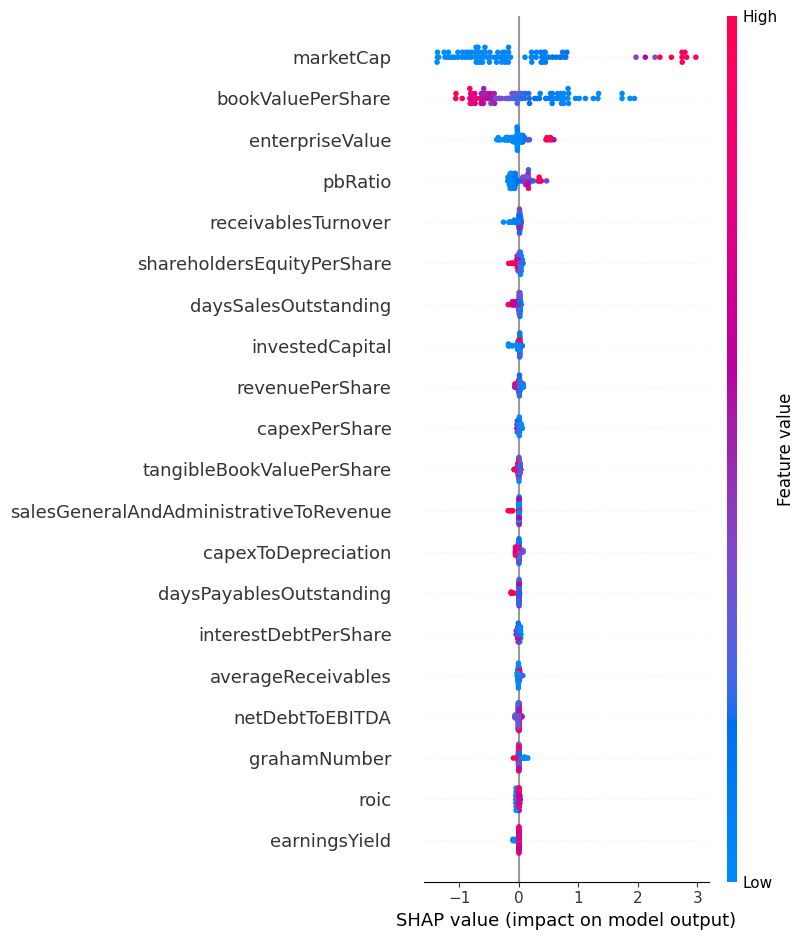

In [ ]:
# Step-by-step implementation of Relative Valuation using LightGBM

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("10year_fundamentals.csv")

# 2. Create target variables (log of valuation ratios)
df['ln_m2b'] = np.log(df['marketCap'] / df['bookValuePerShare'])
df['ln_ev2s'] = np.log(df['enterpriseValue'] / df['revenuePerShare'])

# 3. Clean data: remove invalid values
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['ln_m2b', 'ln_ev2s'])

# 4. Select numeric features
X = df.select_dtypes(include=[np.number]).drop(columns=['ln_m2b', 'ln_ev2s'])
X = X.fillna(X.median())  # Impute missing values

# 5. Define target
y = df['ln_m2b']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train LightGBM
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# 8. Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 9. Show Predicted vs Actual
results = pd.DataFrame({
    "Actual ln(M/B)": y_test.values,
    "Predicted ln(M/B)": y_pred
})
print(results)

# 10. SHAP Interpretability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = list(set(nasdaq100_in_sp500 + ['ARM']))  # Add ARM manually

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


# ⏳ Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess
cols_needed = ['book_value','current_price','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','industry','pe_ratio','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']

train_df = train_df.dropna(subset=cols_needed)
test_df = test_df.dropna(subset=cols_needed[:-1])  # we will predict pe_ratio

# Encode industry
# Fit label encoder on training data
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Create a mapping and apply it safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)

# Handle unseen industries (fill with -1)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'current_price'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100
test_df['predicted_current_price'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_current_price'] > row['current_price'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','predicted_current_price','valuation','pe_ratio','book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps']]
output.to_csv("nasdaq100_current_price_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(10))
# ✅ Check if ARM is included
if 'ARM' in output['ticker'].values:
    print("ARM is included in the final output.")
else:
    print("ARM is NOT included in the final output.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 12
[LightGBM] [Info] Start training from score 188.160085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
print("Test tickers:", test_tickers)
print("Is ARM included?", 'ARM' in test_tickers)


Test tickers: ['MAR', 'TSCO', 'WTW', 'PAYX', 'PCAR', 'FTNT', 'GEN', 'WBD', 'SMCI', 'GILD', 'CSCO', 'REG', 'CZR', 'CHTR', 'ADSK', 'TXN', 'ACGL', 'CPB', 'EA', 'PODD', 'CSX', 'NVDA', 'HON', 'TSLA', 'FITB', 'TTWO', 'DDOG', 'NTRS', 'ALGN', 'CEG', 'EVRG', 'ODFL', 'KMB', 'HSIC', 'EXPE', 'HST', 'CDNS', 'CSGP', 'NDSN', 'EBAY', 'PYPL', 'NDAQ', 'JKHY', 'KHC', 'GEHC', 'LULU', 'INCY', 'ERIE', 'ISRG', 'LNT', 'LKQ', 'INTC', 'FOX', 'UAL', 'STX', 'ULTA', 'ORLY', 'TTD', 'EQIX', 'FFIV', 'AAPL', 'CDW', 'CTSH', 'COIN', 'ADI', 'CTAS', 'ARM', 'XEL', 'PEP', 'CPRT', 'MSFT', 'FANG', 'PTC', 'WDC', 'AMAT', 'MDLZ', 'COO', 'DXCM', 'NTAP', 'AEP', 'CRWD', 'ENPH', 'STLD', 'POOL', 'ABNB', 'MKTX', 'DLTR', 'VRTX', 'TECH', 'GOOGL', 'ROST', 'QCOM', 'KDP', 'DASH', 'PLTR', 'NXPI', 'AXON', 'KLAC', 'LRCX', 'AMGN', 'ON', 'ADBE', 'TER', 'TRMB', 'VRSN', 'FOXA', 'WDAY', 'MCHP', 'AMD', 'ZBRA', 'AMZN', 'GOOG', 'NFLX', 'SBAC', 'APA', 'LIN', 'CHRW', 'AVGO', 'BIIB', 'DPZ', 'BKNG', 'JBHT', 'MRNA', 'EXC', 'WYNN', 'MPWR', 'INTU', 'VTRS', 

In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm

# 📚 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# 📥 Step 1: Load ticker lists
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))

# ✅ Include ARM manually
test_tickers = list(set(nasdaq100_in_sp500 + ['ARM']))

# 📊 Step 2: Fetch fundamentals
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')

        # Calculate PEG ratio properly
        if pe_ratio is not None and eps_growth not in (None, 0):
            peg_ratio = pe_ratio / (eps_growth * 100)
        else:
            peg_ratio = None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# ⏳ Step 2b: Fetch data
train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# 🧹 Step 3: Preprocess - Handle missing values instead of dropping
numeric_cols = ['book_value','current_price','div_yield','profit_margins','roa','roe',
                'dte','rev_per_share','eps','pe_ratio','peg_ratio','ev_to_ebitda','ebitda_margin']

# Fill numeric columns with median from training data
for col in numeric_cols:
    median_value = train_df[col].median() if col in train_df.columns else 0
    train_df[col] = train_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

# Handle industry column
train_df['industry'] = train_df['industry'].fillna('Other')
test_df['industry'] = test_df['industry'].fillna('Other')

# Encode industry
le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])

# Map to test data safely
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

# Features & Target
features = ['book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'current_price'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# 🤖 Step 4: Train Model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# 🎯 Step 5: Predict for NASDAQ-100 + ARM
test_df['predicted_current_price'] = model.predict(X_test)

# 🏷️ Step 6: Label undervalued/overvalued
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_current_price'] > row['current_price'] else 'Overvalued',
    axis=1
)

# 💾 Step 7: Save result
output = test_df[['ticker','industry','current_price','predicted_current_price','valuation',
                  'pe_ratio','book_value','div_yield','profit_margins','roa','roe',
                  'dte','rev_per_share','eps']]

output.to_csv("nasdaq100_current_price_predictions.csv", index=False)

# 🖨️ Show top results
print(output.head(15))

# ✅ Check if ARM is included
if 'ARM' in output['ticker'].values:
    print("ARM is included in the final output.")
else:
    print("ARM is NOT included in the final output.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 345, number of used features: 12
[LightGBM] [Info] Start training from score 224.836462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
!pip install yfinance lightgbm pandas numpy fredapi scikit-learn

In [ ]:
# 📦 Install if needed
# !pip install yfinance lightgbm pandas numpy fredapi scikit-learn

# 📚 Imports
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from fredapi import Fred
import lightgbm as lgb

# ==============================
# Step 0: FRED API for risk-free rate
# ==============================
fred_api_key = "2b045fcd378377e27d5d1f3feac9cbfe"  # Replace with your FRED key
fred = Fred(api_key=fred_api_key)

def get_risk_free_rate():
    try:
        ten_yield_series = fred.get_series_latest_release('DGS10')
        ten_yield = ten_yield_series.values[0]
        return ten_yield / 100
    except:
        return 0.03  # fallback 3%

# ==============================
# Step 1: Load Tickers
# ==============================
sp500 = pd.read_csv("https://datahub.io/core/s-and-p-500-companies/r/constituents.csv")
nasdaq = pd.read_csv("https://datahub.io/core/nasdaq-listings/r/nasdaq-listed.csv")

sp500_tickers = sp500['Symbol'].tolist()
nasdaq_tickers = nasdaq['Symbol'].tolist()

nasdaq100_in_sp500 = list(set(nasdaq_tickers).intersection(set(sp500_tickers)))
train_tickers = list(set(sp500_tickers) - set(nasdaq100_in_sp500))
test_tickers = list(set(nasdaq100_in_sp500 + ['ARM']))  # Include ARM

# ==============================
# Step 2: Fetch fundamentals
# ==============================
def fetch_fundamentals(ticker):
    try:
        info = yf.Ticker(ticker).info

        pe_ratio = info.get('trailingPE')
        eps_growth = info.get('earningsQuarterlyGrowth')
        peg_ratio = pe_ratio / (eps_growth * 100) if pe_ratio and eps_growth not in (None, 0) else None

        return {
            'ticker': ticker,
            'industry': info.get('industry'),
            'book_value': info.get('bookValue'),
            'current_price': info.get('currentPrice'),
            'div_yield': info.get('dividendYield'),
            'profit_margins': info.get('profitMargins'),
            'roa': info.get('returnOnAssets'),
            'roe': info.get('returnOnEquity'),
            'dte': info.get('debtToEquity'),
            'rev_per_share': info.get('revenuePerShare'),
            'eps': info.get('trailingEps'),
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ev_to_ebitda': info.get('enterpriseToEbitda'),
            'ebitda_margin': info.get('ebitdaMargins'),
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

train_data = [fetch_fundamentals(t) for t in train_tickers]
train_df = pd.DataFrame([d for d in train_data if d is not None])

test_data = [fetch_fundamentals(t) for t in test_tickers]
test_df = pd.DataFrame([d for d in test_data if d is not None])

# ==============================
# Step 3: Preprocess
# ==============================
numeric_cols = ['book_value','current_price','div_yield','profit_margins','roa','roe',
                'dte','rev_per_share','eps','pe_ratio','peg_ratio','ev_to_ebitda','ebitda_margin']

for col in numeric_cols:
    median_value = train_df[col].median() if col in train_df.columns else 0
    train_df[col] = train_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

train_df['industry'] = train_df['industry'].fillna('Other')
test_df['industry'] = test_df['industry'].fillna('Other')

le = LabelEncoder()
train_df['industry_encoded'] = le.fit_transform(train_df['industry'])
industry_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
test_df['industry_encoded'] = test_df['industry'].map(industry_mapping)
test_df['industry_encoded'] = test_df['industry_encoded'].fillna(-1).astype(int)

features = ['book_value','div_yield','profit_margins','roa','roe',
            'dte','rev_per_share','eps','industry_encoded','peg_ratio', 'ev_to_ebitda', 'ebitda_margin']
target = 'current_price'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

# ==============================
# Step 4: Train LightGBM
# ==============================
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

test_df['predicted_current_price'] = model.predict(X_test)
test_df['valuation'] = test_df.apply(
    lambda row: 'Undervalued' if row['predicted_current_price'] > row['current_price'] else 'Overvalued',
    axis=1
)

# ==============================
# Step 5: DCF Calculation
# ==============================
def calculate_dcf(ticker):
    try:
        company = yf.Ticker(ticker)
        info = company.info
        cf = company.cashflow
        bs = company.balance_sheet

        market_cap = info.get('marketCap', np.nan)
        debt = bs.loc['Total Debt'][0] if 'Total Debt' in bs.index else 0
        cash = bs.loc['Cash And Cash Equivalents'][0] if 'Cash And Cash Equivalents' in bs.index else 0
        shares_outstanding = info.get('sharesOutstanding', 1e9)

        # Risk-free
        rf = get_risk_free_rate()

        # Market return approx 5Y S&P 500 CAGR
        sp500_hist = yf.Ticker("^GSPC").history(period="5y")['Close']
        market_return = (sp500_hist[-1]/sp500_hist[0])**(1/5) -1

        beta = info.get('beta',1.0)
        cost_of_equity = rf + beta*(market_return - rf)

        # Cost of debt
        interest_expense = cf.loc['Interest Paid Supplemental Data'][0] if 'Interest Paid Supplemental Data' in cf.index else 0.01*debt
        cost_of_debt = interest_expense / debt if debt>0 else 0.0

        # Tax rate
        net_income = cf.loc['Net Income From Continuing Operations'][0] if 'Net Income From Continuing Operations' in cf.index else 1
        tax_expense = bs.loc['Total Tax Payable'][0] if 'Total Tax Payable' in bs.index else 0.2*net_income
        tax_rate = tax_expense/net_income

        V = market_cap + debt - cash
        E = market_cap
        D = debt
        WACC = ((E/V)*cost_of_equity + (D/V)*cost_of_debt*(1-tax_rate)) if V>0 else cost_of_equity

        # Free cash flow
        o_cash_flow = cf.loc['Cash Flow From Continuing Operating Activities'][0] if 'Cash Flow From Continuing Operating Activities' in cf.index else 0
        capex = cf.loc['Capital Expenditure'][0] if 'Capital Expenditure' in cf.index else 0
        fcf = o_cash_flow + capex

        growth_rate = 0.05  # conservative assumption
        years = 5
        fcf_proj = [fcf*((1+growth_rate)**i) for i in range(1, years+1)]

        terminal_growth = 0.03
        terminal_value = fcf_proj[-1]*(1+terminal_growth)/(WACC-terminal_growth) if WACC>terminal_growth else fcf_proj[-1]*(1+terminal_growth)/0.05

        pv_fcf = sum([fcf_proj[i]/((1+WACC)**(i+1)) for i in range(years)])
        pv_terminal = terminal_value/((1+WACC)**years)

        dcf_total = pv_fcf + pv_terminal
        dcf_per_share = dcf_total / shares_outstanding
        return round(dcf_per_share,2)
    except Exception as e:
        print(f"DCF error for {ticker}: {e}")
        return np.nan

# Apply DCF to all test tickers
test_df['dcf_value'] = test_df['ticker'].apply(calculate_dcf)

# ==============================
# Step 6: Save output
# ==============================
output_cols = ['ticker','industry','current_price','predicted_current_price','valuation',
               'pe_ratio','book_value','div_yield','profit_margins','roa','roe',
               'dte','rev_per_share','eps','dcf_value']



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 345, number of used features: 12
[LightGBM] [Info] Start training from score 223.656372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/tmp/ipython-input-3884527663.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  debt = bs.loc['Total Debt'][0] if 'Total Debt' in bs.index else 0
/tmp/ipython-input-3884527663.py:130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cash = bs.loc['Cash And Cash Equivalents'][0] if 'Cash And Cash Equivalents' in bs.index else 0
/tmp/ipython-input-3884527663.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_return = (sp500